# Monte Carlo Options

 This is an attempt at pricing Call options using a Monte Carlo simulation and the Black Scholes Formula 


## Import some libraries
Useful to manage data and do computations

In [0]:
# standard data science toolkit
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from math import sqrt, exp

# useful to properly order columns in pandas DataFrame
from collections import OrderedDict

In [0]:
# some visualization boilerplate
pd.options.display.max_rows = 10
pd.options.display.max_columns = 10
pd.options.display.float_format = '{:.4f}'.format
pd.options.mode.chained_assignment = None 

In [3]:
# install Google Finance library
!pip install googlefinance.client

    100% |████████████████████████████████| 61kB 801kB/s 
    100% |████████████████████████████████| 174kB 3.7MB/s 
  Running setup.py bdist_wheel for googlefinance.client ... - done
  Stored in directory: /content/.cache/pip/wheels/bf/d6/54/09b6ac5690820dc54556f021efcfd6baca88f04b144a001c55
Successfully built googlefinance.client


In [0]:
# function from the Google Finance lib that allows us to retrieve stock prices
from googlefinance.client import get_price_data

## Set constants

Here, we'll set the annual risk free rate as a constant

In [0]:
RISK_FREE_RATE = 1.17 / 100 # found somewhere on the internet

## Retrieve stock data
We'll do this using the Google Finance get_price_data A.P.I

In [6]:
def get_stock(symbol, exchange):
  '''
  inputs:
    symbol: str, representing the symbol of the stock (ex: 'GOOG')
    exchange: str, representing the exchange on which the stock is traded (ex: 'NASDAQ')
  output:
    stock Pandas DataFrame with columns 'Close' and 'Returns'
  '''
  stock = get_price_data({
    'q': symbol,
    'i': "86400", # Interval size in seconds ("86400" = 1 day intervals)
    'x': exchange,
    'p': "1Y" # Period (Ex: "1Y" = 1 year)  
  })[['Close']]
  stock['Returns'] = stock['Close'].pct_change()
  return stock

def get_stock_annualized_volatility(stock):
  '''
  inputs:
    stock: stock DataFrame
  returns:
    float representing stock annualized volatility
  '''
  return stock['Returns'].std() * sqrt(252)

# little example of the usage of the 2 functions above
goog = get_stock('GOOG', 'NASDAQ')
vol = get_stock_annualized_volatility(goog)

print("Annualized volatility:", vol)
goog.head()

('Annualized volatility:', 0.1948117601082517)


,Close,Returns
2017-03-15 20:00:00,847.2000,nan
2017-03-16 20:00:00,848.7800,0.0019
2017-03-17 20:00:00,852.1200,0.0039
2017-03-20 20:00:00,848.4000,-0.0044
2017-03-21 20:00:00,830.4600,-0.0211


## Now let's dive into the Monte Carlo simulation
We'll use the Black Scholes formula to simulate the stock value after a certain period

In [0]:
def black_scholes(S, r, sig, Tmt, n):
  '''
  inputs:
    S: float, the underlying stock price
    r: float, the annualized risk free rate
    sig: float, the annualized volatility of the underlying stock
    Tmt: float, "T minus t" meaning the remaining time before the expiry date,
      expressed as a % of a year
    n: number of outcomes to simulate
   output:
    numpy.array of shape (n,) containing the n simulations
  
  '''
  return (S * np.exp((r - 0.5 * sig**2) * Tmt + sig * sqrt(Tmt) * 
                     np.random.standard_normal(n)))

In [0]:
def simulate(
    stock_price, volatility,
    end_date, risk_free_rate,
    strike_price, nb_simulations):
  '''
  inputs:
    stock_price: float representing the underlying price
    volatility: annualized stock volatility
    end_date: datetime representing expiry date (format: '2018-03-14')
    risk_free_rate: float representing risk free interest rate to discount by
    strike_price: float representing the price of the strike
    nb_simulation: integer representing the number of simulations to run
  
  output:
    simulation pd.DataFrame with columns 'Asset price', 'Payoff' and 
      'Discounted payoff'
  '''
  remaining_time = (datetime.strptime(end_date, '%Y-%m-%d') - 
                    datetime.now()).days / 365.0
  discount_factor = exp(-risk_free_rate * remaining_time)
  simulated_prices = black_scholes(stock_price, risk_free_rate, 
                                   volatility, remaining_time, nb_simulations)
  payoffs = (simulated_prices - strike_price).clip(0)
  discounted_payoffs = payoffs * discount_factor
  return pd.DataFrame(OrderedDict([
    ('Asset price', simulated_prices),
    ('Payoff', payoffs),
    ('Discounted payoff', discounted_payoffs)
  ]))

We can now automatically retrieve historical data for a stock, compute its volatility and run simulations for a given strike price and expiry date.

By averaging the discounted payoff, I can get a price estimate for the Call option.

***Note:*** *This would be the option price if it was a European style option. I have no idea how to compute the price of an American style option*

In [0]:
def price_option(symbol, exchange, end_date, strike_price, nb_simulations):
  stock = get_stock(symbol, exchange)
  S = stock['Close'][-1]
  vol = get_stock_annualized_volatility(stock)
  simulation = simulate(S, vol, end_date, RISK_FREE_RATE, 
                        strike_price, nb_simulations)
  return simulation['Discounted payoff'].mean()

## Let's try it out

I found on Yahoo Finance an option for Apple expiring on April 13th 2018 with a strike price of 135 valued at 48.3.

I can run a million simulations to try and find out if the option is over-priced or under-priced.

In [10]:
symbol = 'AAPL'
exchange = 'NASDAQ'
expiry_date = '2018-04-13'
strike_price = 135

nb_simulations = 1000000

estimated_price = price_option(symbol, exchange, expiry_date, 
                               strike_price, nb_simulations)

print("Underlying Stock:", symbol)
print("Option expiry date:", expiry_date)
print("Option strike price:", strike_price)
print("Estimated price:", estimated_price)

('Underlying Stock:', 'AAPL')
('Option expiry date:', '2018-04-13')
('Option strike price:', 135)
('Estimated price:', 43.5672822833136)


So the option on Yahoo Finance seems a bit over-priced, but again, the estimated price I computed would be relevant if the option was European style, which is not the case.

## More fun things

Ok, so it turns out you can use an American option anytime during its lifetime.

I'll try to simulate the price for every day until the expiry date.

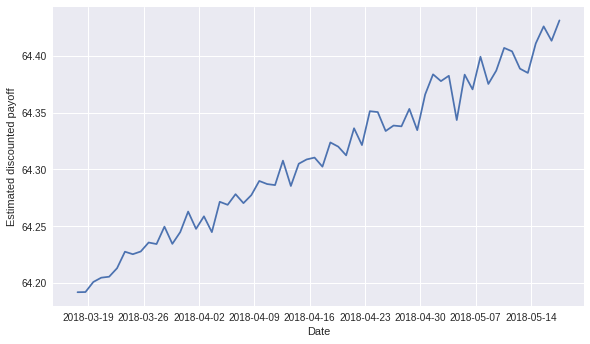

In [11]:
symbol = 'FB'
exchange = 'NASDAQ'
expiry_date = '2018-05-18'
strike_price = 120

nb_simulations = 1000000

stock = get_stock(symbol, exchange)
S = stock['Close'][-1]
vol = get_stock_annualized_volatility(stock)

start_date = datetime.now() + timedelta(days=2)
exp_datetime = datetime.strptime(expiry_date, '%Y-%m-%d')
dates = []
simulations = []
while start_date <= exp_datetime:
  dates.append(start_date)
  simulation = simulate(S, vol, start_date.strftime('%Y-%m-%d'), RISK_FREE_RATE, 
                        strike_price, nb_simulations)
  simulations.append(simulation)
  start_date += timedelta(days=1)
  
prices = [simulation['Discounted payoff'].mean() for simulation in simulations]

matplotlib.rcParams['figure.figsize'] = [9.5, 5.5]
plt.plot(dates, prices)
plt.ylabel('Estimated discounted payoff')
plt.xlabel('Date')
plt.show()

Alright, now I want to do this 100 times and plot everything on the same graph.

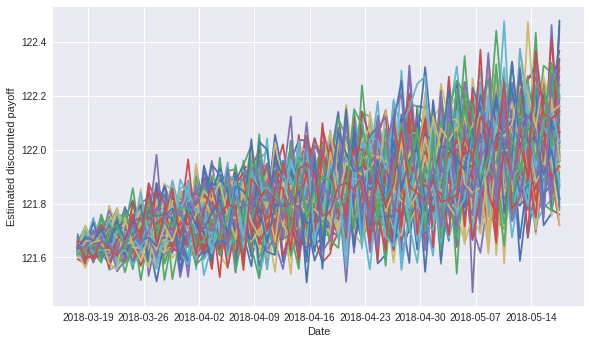

In [12]:
symbol = 'TSLA'
exchange = 'NASDAQ'
expiry_date = '2018-05-18'
strike_price = 205.0

nb_simulations = 100000 # reducing that a bit

stock = get_stock(symbol, exchange)
S = stock['Close'][-1]
vol = get_stock_annualized_volatility(stock)

exp_datetime = datetime.strptime(expiry_date, '%Y-%m-%d')

prices_2d = []
dates_2d = []
for i in range(0, 100):
  dates = []
  simulations = []
  start_date = datetime.now() + timedelta(days=2)
  while start_date <= exp_datetime:
    dates.append(start_date)
    simulation = simulate(S, vol, start_date.strftime('%Y-%m-%d'), RISK_FREE_RATE, 
                          strike_price, nb_simulations)
    simulations.append(simulation)
    start_date += timedelta(days=1)
  prices = [simulation['Discounted payoff'].mean() for simulation in simulations]
  prices_2d.append(prices)
  dates_2d.append(dates)

for prices, dates in zip(prices_2d, dates_2d):
  plt.plot(dates, prices)

plt.ylabel('Estimated discounted payoff')
plt.xlabel('Date')
plt.show()